In [ ]:
# !nvidia-smi

In [ ]:
import tensorflow as tf

tf.config.list_physical_devices("GPU")

2024-07-11 09:27:04.000688: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9373] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-11 09:27:04.000752: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-11 09:27:04.002304: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1534] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-11 09:27:04.010485: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import pandas as pd

df = pd.read_csv(
    "/workspace/ADNN/Exp-5/Dataset/medium_articles.csv",
)
df = df[["text"]]
df.head()

,text
0,Photo by Josh Riemer on Unsplash\n\nMerry Chri...
1,Your Brain On Coronavirus\n\nA guide to the cu...
2,Mind Your Nose\n\nHow smell training can chang...
3,Passionate about the synergy between science a...
4,"You’ve heard of him, haven’t you? Phineas Gage..."


In [ ]:
n = int(0.9 * len(df))  # first 90% will be train, rest val
train_examples = df[:n]
val_examples = df[n:]

In [ ]:
train_examples = tf.data.Dataset.from_tensor_slices((train_examples))
val_examples = tf.data.Dataset.from_tensor_slices((val_examples))

2024-07-11 09:27:17.919116: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1926] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 17947 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB MIG 3g.20gb, pci bus id: 0000:b7:00.0, compute capability: 8.0


In [ ]:
max_features = 5000  # Maximum vocab size
BATCH_SIZE = 32
MAX_TOKENS = 128
BUFFER_SIZE = 1000
vectorize_layer = tf.keras.layers.TextVectorization(
    standardize="lower_and_strip_punctuation",
    max_tokens=max_features,
)
vectorize_layer.adapt(train_examples, batch_size=None)

In [ ]:
vocabulary = vectorize_layer.get_vocabulary()

In [ ]:
def prepare_batch(data):
    x = vectorize_layer(data)
    x = x[:, :(MAX_TOKENS)]  # Trim to MAX_TOKENS
    X_train = x[:, :-1]  # Shift by one
    y_train = x[:, 1:]  # Shift by one
    return (X_train, y_train)

In [ ]:
def make_batches(ds):
    return (
        ds.shuffle(BUFFER_SIZE)
        .batch(BATCH_SIZE)
        .map(prepare_batch, tf.data.AUTOTUNE)
        .prefetch(buffer_size=tf.data.AUTOTUNE)
    )

In [ ]:
# Create training and validation set batches
train_batches = make_batches(train_examples)
val_batches = make_batches(val_examples)

In [ ]:
for X_train, y_train in train_batches.take(1):
    break
print(X_train.shape)
print(y_train.shape)

(32, 127)
(32, 127)


In [ ]:
for x_batch, y_batch in train_batches.take(1):
    break

In [ ]:
x_batch.shape
y_batch.shape

TensorShape([32, 127])

In [ ]:
def positional_encoding(length, depth):
    depth = depth / 2

    positions = np.arange(length)[:, np.newaxis]  # (seq, 1)
    depths = np.arange(depth)[np.newaxis, :] / depth  # (1, depth)

    angle_rates = 1 / (10000**depths)  # (1, depth)
    angle_rads = positions * angle_rates  # (pos, depth)

    pos_encoding = np.concatenate([np.sin(angle_rads), np.cos(angle_rads)], axis=-1)

    return tf.cast(pos_encoding, dtype=tf.float32)

In [ ]:
pos_encoding = positional_encoding(length=2048, depth=512)

# Check the shape.
print(pos_encoding.shape)

# Plot the dimensions.
plt.pcolormesh(pos_encoding.numpy().T, cmap="RdBu")
plt.ylabel("Depth")
plt.xlabel("Position")
plt.colorbar()
plt.show()

(2048, 512)


In [ ]:
class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, vocab_size, d_model):
        super().__init__()
        self.d_model = d_model
        self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True)
        self.pos_encoding = positional_encoding(length=2048, depth=d_model)

    def compute_mask(self, *args, **kwargs):
        return self.embedding.compute_mask(*args, **kwargs)

    def call(self, x):
        length = tf.shape(x)[1]
        x = self.embedding(x)
        # This factor sets the relative scale of the embedding and positonal_encoding.
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x = x + self.pos_encoding[tf.newaxis, :length, :]
        return x

In [ ]:
class BaseAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()

class CausalSelfAttention(BaseAttention):
    def call(self, x):
        attn_output, attn_scores = self.mha(
            query=x, value=x, key=x, return_attention_scores=True, use_causal_mask=True
        )
        # Cache the attention scores for plotting later.
        self.last_attn_scores = attn_scores
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

In [ ]:
# Example usage:
d_model = 512
vocab_size = 8000
# Create positional embedding layer
pos_embedding_layer = PositionalEmbedding(vocab_size, d_model)
x_batch_emb = pos_embedding_layer(x_batch)

# print("Input shape:", x_batch.shape)
print("Embedded output shape:", x_batch_emb.shape)
sample_csa = CausalSelfAttention(num_heads=2, key_dim=512)
x_batch_emb = sample_csa(x_batch_emb)
# print(x_batch.shape)
print(x_batch_emb.shape)

Embedded output shape: (32, 127, 512)
(32, 127, 512)


2024-07-11 09:29:40.939353: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:467] Loaded cuDNN version 90100


In [ ]:
class FeedForward(tf.keras.layers.Layer):
    def __init__(self, d_model, dff, dropout_rate=0.1):
        super().__init__()
        self.seq = tf.keras.Sequential(
            [
                tf.keras.layers.Dense(dff, activation="relu"),
                tf.keras.layers.Dense(d_model),
                tf.keras.layers.Dropout(dropout_rate),
            ]
        )
        self.add = tf.keras.layers.Add()
        self.layer_norm = tf.keras.layers.LayerNormalization()

    def call(self, x):
        x = self.add([x, self.seq(x)])
        x = self.layer_norm(x)
        return x

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, *, d_model, num_heads, dff, dropout_rate=0.1):
        super(DecoderLayer, self).__init__()

        self.causal_self_attention = CausalSelfAttention(
            num_heads=num_heads, key_dim=d_model, dropout=dropout_rate
        )

        self.ffn = FeedForward(d_model, dff)

    def call(self, x):
        x = self.causal_self_attention(x=x)
        # Cache the last attention scores for plotting later
        self.last_attn_scores = self.causal_self_attention.last_attn_scores
        x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.
        return x

In [ ]:
class Decoder(tf.keras.layers.Layer):
    def __init__(
        self, *, num_layers, d_model, num_heads, dff, vocab_size, dropout_rate=0.1
    ):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size, d_model=d_model)
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.dec_layers = [
            DecoderLayer(
                d_model=d_model, num_heads=num_heads, dff=dff, dropout_rate=dropout_rate
            )
            for _ in range(num_layers)
        ]

        self.last_attn_scores = None

    def call(self, x):
        # `x` is token-IDs shape (batch, target_seq_len)
        x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)

        x = self.dropout(x)

        for i in range(self.num_layers):
            x = self.dec_layers[i](x)

        self.last_attn_scores = self.dec_layers[-1].last_attn_scores

        # The shape of x is (batch_size, target_seq_len, d_model).
        return x

In [ ]:
# Instantiate the decoder.
sample_decoder = Decoder(
    num_layers=4, d_model=512, num_heads=8, dff=2048, vocab_size=8000
)

output = sample_decoder(x=x_batch)

# Print the shapes.
print(x_batch.shape)
print(x_batch_emb.shape)
print(output.shape)

(32, 127)
(32, 127, 512)
(32, 127, 512)


In [ ]:
import tensorflow as tf

# Define your PositionalEmbedding, BaseAttention, and CausalSelfAttention classes here
# They should include necessary layers and methods as previously discussed

class Transformer(tf.keras.Model):
    def __init__(
        self, *, num_layers, d_model, num_heads, dff, input_vocab_size, dropout_rate=0.1
    ):
        super().__init__()

        self.decoder = Decoder(
            num_layers=num_layers,
            d_model=d_model,
            num_heads=num_heads,
            dff=dff,
            vocab_size=input_vocab_size,
            dropout_rate=dropout_rate,
        )

        self.final_layer = tf.keras.layers.Dense(input_vocab_size)

    def call(self, inputs):
        x = inputs
        x = self.decoder(x)  # (batch_size, target_len, d_model)
        logits = self.final_layer(x)  # (batch_size, target_len, target_vocab_size)

        try:
            del logits._keras_mask
        except AttributeError:
            pass

        return logits

class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super().__init__()
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        step = tf.cast(step, dtype=tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

# Example setup for training
num_layers = 4  # Number of transformer layers
num_heads = 8  # Number of attention heads
dff = 2048  # Dimensionality of the feed-forward layer
dropout_rate = 0.1  # Dropout rate

# Initialize the Transformer model
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=vocab_size,
    dropout_rate=dropout_rate,
)


In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super().__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        step = tf.cast(step, dtype=tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9
)

In [ ]:
def masked_loss(label, pred):
    mask = label != 0
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction="none"
    )
    loss = loss_object(label, pred)

    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    loss = tf.reduce_sum(loss) / tf.reduce_sum(mask)
    return loss


def masked_accuracy(label, pred):
    pred = tf.argmax(pred, axis=2)
    label = tf.cast(label, pred.dtype)
    match = label == pred

    mask = label != 0

    match = match & mask

    match = tf.cast(match, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(match) / tf.reduce_sum(mask)

In [ ]:
transformer.compile(loss=masked_loss, optimizer=optimizer, metrics=[masked_accuracy])
history = transformer.fit(train_batches, epochs=1, validation_data=val_batches)

5411/5411 [==============================] - 523s 96ms/step - loss: 4.5585 - masked_accuracy: 0.2241 - val_loss: 4.3594 - val_masked_accuracy: 0.2404


<Axes: >

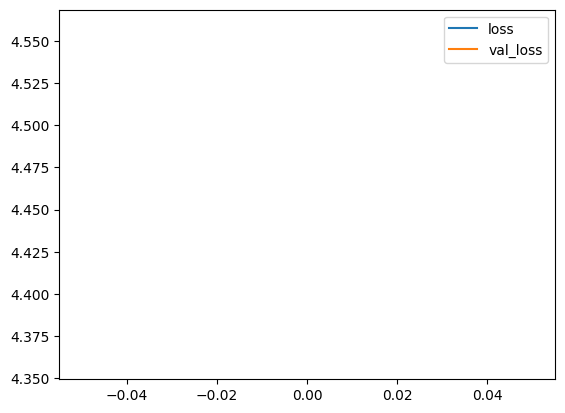

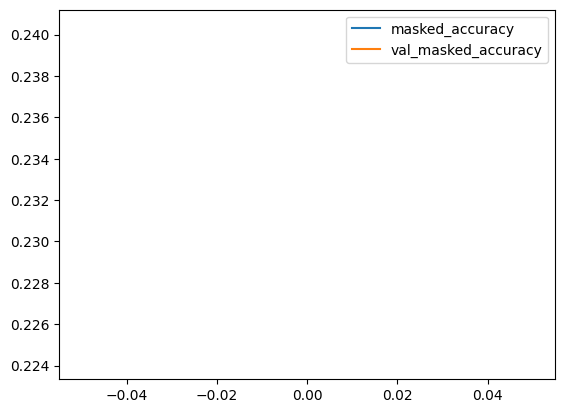

In [ ]:
metrics_df = pd.DataFrame(history.history)
metrics_df[["loss", "val_loss"]].plot()
metrics_df[["masked_accuracy", "val_masked_accuracy"]].plot()

In [ ]:
sentence = "Python"
x = vectorize_layer(sentence)
x = tf.expand_dims(x, axis=0)
prediction = transformer(x)
predicted_id = tf.argmax(prediction, axis=-1)
id_to_word = tf.keras.layers.StringLookup(
    vocabulary=vocabulary, mask_token="", oov_token="[UNK]", invert=True
)

In [ ]:
x_concat = tf.experimental.numpy.append(x, predicted_id[0], axis=None)

In [ ]:
class Generator(tf.Module):
    def __init__(
        self,
        tokenizer,
        vocabulary,
        transformer,
        max_new_tokens,
        temperature=0.0,
    ):
        self.tokenizer = tokenizer
        self.transformer = transformer
        self.vocabulary = vocabulary
        self.max_new_tokens = max_new_tokens
        self.temperature = temperature

    def __call__(self, sentence, max_length=MAX_TOKENS):
        sentence = self.tokenizer(sentence)
        sentence = tf.expand_dims(sentence, axis=0)
        encoder_input = sentence
        # `tf.TensorArray` is required here (instead of a Python list), so that the
        # dynamic-loop can be traced by `tf.function`.
        output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)

        print(f"Generating {self.max_new_tokens} tokens")
        for i in tf.range(self.max_new_tokens):
            output = tf.transpose(output_array.stack())
            predictions = self.transformer(encoder_input, training=False)

            # Select the last token from the `seq_len` dimension.
            predictions = predictions[:, -1:, :]  # Shape `(batch_size, 1, vocab_size)`.
            if self.temperature == 0.0:
                # greedy sampling, output always the same
                predicted_id = tf.argmax(predictions, axis=-1)
            else:
                predictions = predictions / self.temperature
                predicted_id = tf.random.categorical(predictions[0], num_samples=1)

            # Concatenate the `predicted_id` to the output which is given to the
            # decoder as its input.
            output_array = output_array.write(i + 1, predicted_id[0])
            encoder_input = tf.experimental.numpy.append(encoder_input, predicted_id[0])
            encoder_input = tf.expand_dims(encoder_input, axis=0)

        output = tf.transpose(output_array.stack())
        # The output shape is `(1, tokens)`.
        id_to_word = tf.keras.layers.StringLookup(
            vocabulary=self.vocabulary, mask_token="", oov_token="[UNK]", invert=True
        )

        print(f"Using temperature of {self.temperature}")
        text = id_to_word(output)
        tokens = output

        # `tf.function` prevents us from using the attention_weights that were
        # calculated on the last iteration of the loop.
        # So, recalculate them outside the loop.
        self.transformer(output[:, :-1], training=False)
        attention_weights = self.transformer.decoder.last_attn_scores

        return text, tokens, attention_weights

In [ ]:
def print_generation(sentence, generated_text):
    print(f'{"Input:":15s}: {sentence}')
    print(f'{"Generation":15s}: {generated_text}')

max_new_tokens = 50
temperature = 0.92

generator = Generator(vectorize_layer, vocabulary, transformer, max_new_tokens, temperature)
sentence = "Machine learning"
generated_text, generated_tokens, attention_weights = generator(sentence)
print_generation(sentence, generated_text)

Generating 50 tokens
Using temperature of 0.92
Input:         : Machine learning
Generation     : [[b'' b'[UNK]' b'with' b'[UNK]' b'[UNK]' b'[UNK]' b'[UNK]' b'[UNK]'
  b'[UNK]' b'[UNK]' b'to' b'[UNK]' b'security' b'image' b'courtesy'
  b'[UNK]' b'if' b'you' b'just' b'want' b'to' b'read' b'it' b'from'
  b'the' b'[UNK]' b'of' b'the' b'internet' b'that' b'is' b'possible'
  b'when' b'you' b'need' b'to' b'download' b'the' b'version' b'of'
  b'case' b'you' b'have' b'an' b'online' b'media' b'accounts' b'[UNK]'
  b'[UNK]' b'in' b'person']]


In [ ]:
sentence = "Python"

def plot_attention_weights(sentence, generated_tokens, attention_heads):
    in_tokens = vectorize_layer([sentence])

    fig = plt.figure(figsize=(16, 8))

    for h, head in enumerate(attention_heads):
        ax = fig.add_subplot(2, 4, h + 1)

        plot_attention_weights(in_tokens, generated_tokens, head)

        ax.set_xlabel(f"Head {h+1}")

    plt.tight_layout()
    plt.show()

generated_text, generated_tokens, attention_weights = generator(sentence)
print_generation(sentence, generated_text)
# plot_attention_weights(sentence, generated_tokens, attention_weights[0])
# plt.tight_layout()


Generating 50 tokens
Using temperature of 0.92
Input:         : Python
Generation     : [[b'' b'from' b'[UNK]' b'in' b'every' b'free' b'live' b'online' b'[UNK]'
  b'a' b'[UNK]' b'of' b'income' b'learn' b'how' b'to' b'use' b'linkedin'
  b'machine' b'learning' b'machine' b'learning' b'companies' b'how'
  b'did' b'you' b'pursue' b'a' b'successful' b'career' b'in' b'your'
  b'organization' b'and' b'how' b'could' b'you' b'navigate' b'the'
  b'music' b'sector' b'you' b'ask' b'whether' b'you' b'put' b'a' b'live'
  b'job' b'and' b'not']]
